In [ ]:
!pip install kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!kaggle datasets download -d ninadaithal/imagesoasis

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
 99% 1.22G/1.23G [00:09<00:00, 148MB/s]
100% 1.23G/1.23G [00:09<00:00, 138MB/s]


In [3]:
!unzip /content/imagesoasis.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
  inflating: dataset/Data/Very mild Dementia/OAS1

In [11]:
import os
import shutil
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import cv2
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score

In [5]:
classes = [folder for folder in os.listdir('/content/dataset/Data') if os.path.isdir(os.path.join('/content/dataset/Data', folder))]
print(classes)

['Very mild Dementia', 'Non Demented', 'Mild Dementia', 'Moderate Dementia']


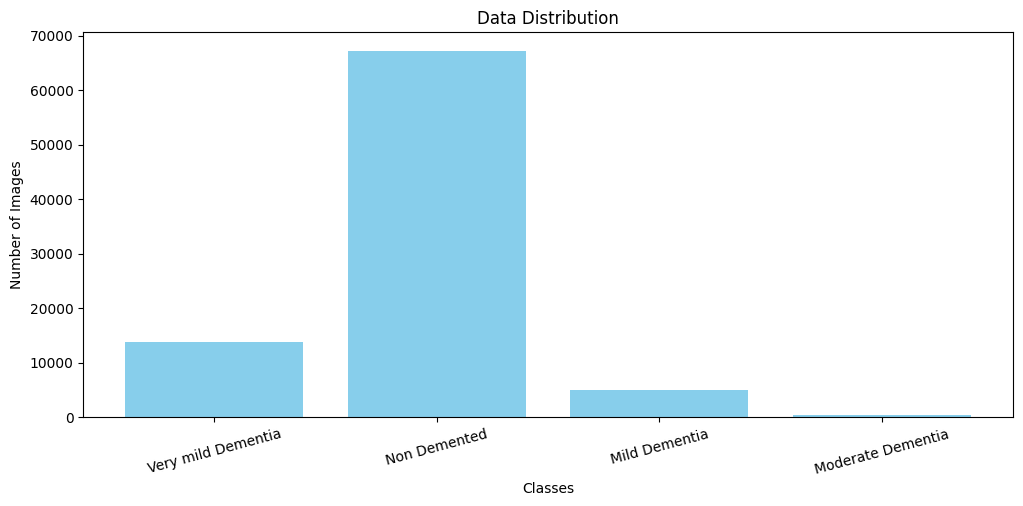

In [6]:
def count_images(base_dir):
    counts = {}
    classes = [cls for cls in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, cls))]

    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        counts[cls] = len(os.listdir(cls_path))

    return counts

dataset = count_images('/content/dataset/Data')
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(dataset.keys(), dataset.values(), color='skyblue')
ax.set_title("Data Distribution")
ax.set_ylabel("Number of Images")
ax.set_xlabel("Classes")
ax.set_xticks(range(len(dataset)))
ax.set_xticklabels(dataset.keys(), rotation=15)

plt.show()

In [7]:
data_dir = "/content/dataset/Data"
output_dir = "Processed_Data"

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

    def copy_images(image_list, split):
        split_path = os.path.join(output_dir, split, class_name)
        os.makedirs(split_path, exist_ok=True)
        for img in image_list:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_path, img))

    copy_images(train_images, 'train')
    copy_images(val_images, 'val')
    copy_images(test_images, 'test')

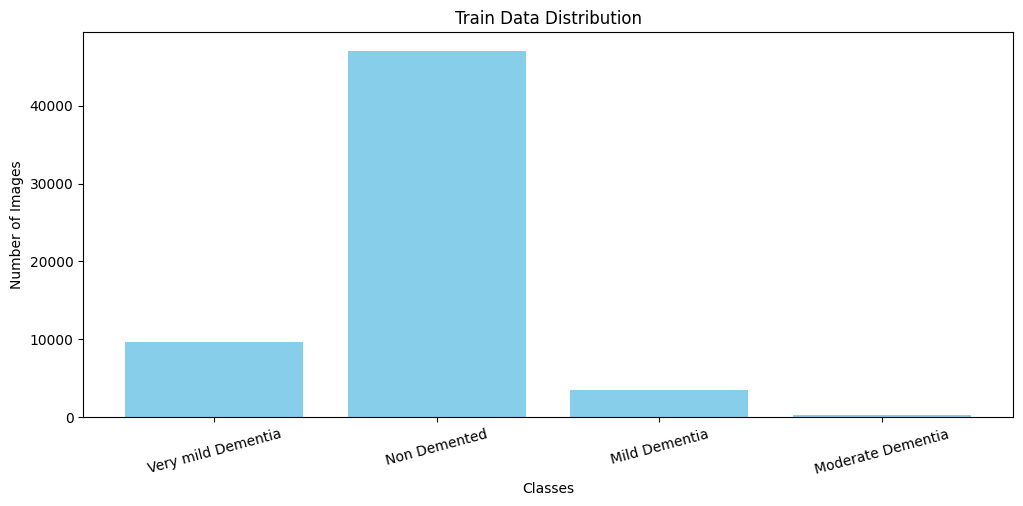

In [8]:
dataset = count_images('/content/Processed_Data/train')
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(dataset.keys(), dataset.values(), color='skyblue')
ax.set_title("Train Data Distribution")
ax.set_ylabel("Number of Images")
ax.set_xlabel("Classes")
ax.set_xticks(range(len(dataset)))
ax.set_xticklabels(dataset.keys(), rotation=15)

plt.show()

In [9]:
transform = transforms.Compose([
      transforms.Resize(300),
      transforms.CenterCrop(300),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(20),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


train_dataset = datasets.ImageFolder(root="Processed_Data/train", transform=transform)
val_dataset = datasets.ImageFolder(root="Processed_Data/val", transform=transform)
test_dataset = datasets.ImageFolder(root="Processed_Data/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
len(train_loader)

3782

In [ ]:
len(val_loader)

1081

In [10]:
len(test_loader)

541

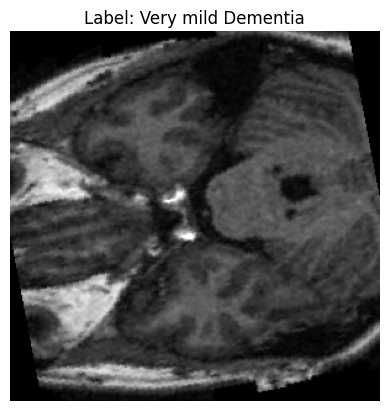

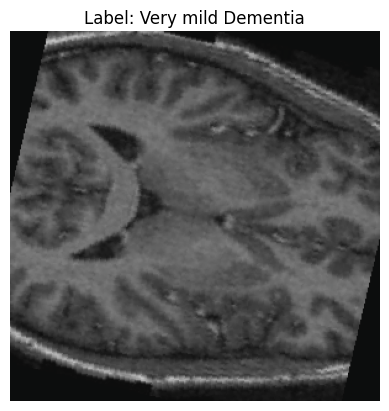

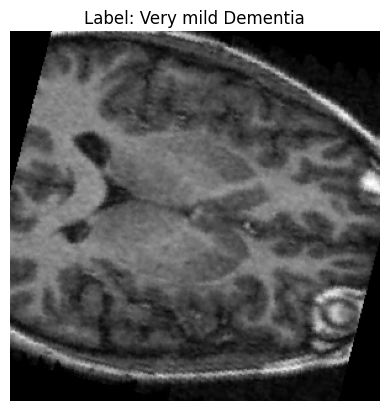

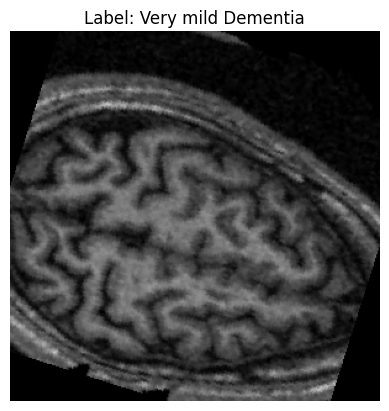

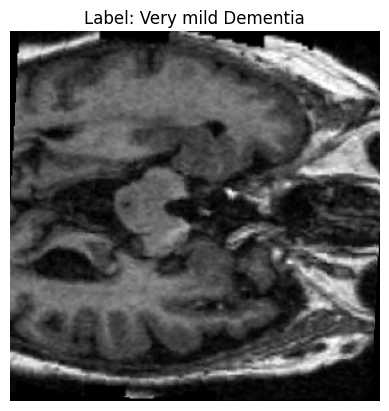

In [ ]:
def show_sample_with_labels(dataloaders, class_names, num_images=5):
    images, labels = next(iter(dataloaders))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.imshow(image)
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')
        plt.show()

show_sample_with_labels(train_loader, classes)

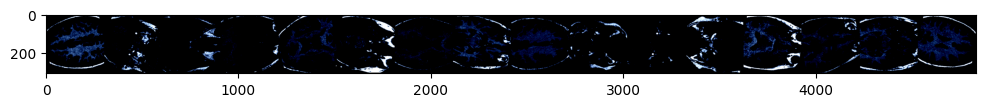

In [ ]:
for images, labels in train_loader:
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

MODEL :

In [ ]:
#ResNet50
num_classes = len(train_dataset.classes)
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


In [ ]:
class BrainNetCnn(nn.Module):
    def __init__(self, num_classes):
        super(BrainNetCnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 37 * 37, 128)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.dropout3(x)
        x = x.view(-1, 64 * 37 * 37)
        x = self.relu4(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

In [ ]:
#MobileNetV3
model = models.mobilenet_v3_large(pretrained=True)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 4)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BrainNetCnn(num_classes=4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        scheduler.step()

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total

        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {history['train_loss'][-1]:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {history['val_loss'][-1]:.4f} | Val Acc: {val_acc:.2f}%")

    return history

history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=3)

Epoch 1/3 | Train Loss: 0.3200 | Train Acc: 86.79% | Val Loss: 0.1753 | Val Acc: 93.08%
Epoch 2/3 | Train Loss: 0.1055 | Train Acc: 96.00% | Val Loss: 0.0676 | Val Acc: 97.49%
Epoch 3/3 | Train Loss: 0.0493 | Train Acc: 98.24% | Val Loss: 0.0761 | Val Acc: 97.26%


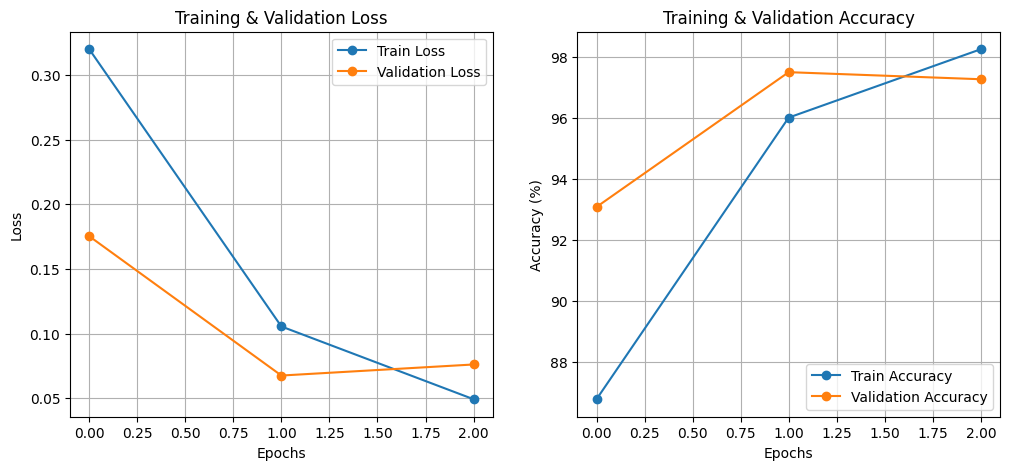

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["val_acc"], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

In [22]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

evaluate_model(model, test_loader)

Test Accuracy: 97.41%


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/MobileNetBrain.pth")

<ipython-input-17-ab7d65173cae>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/MobileNetBrain.pth", map_location=d

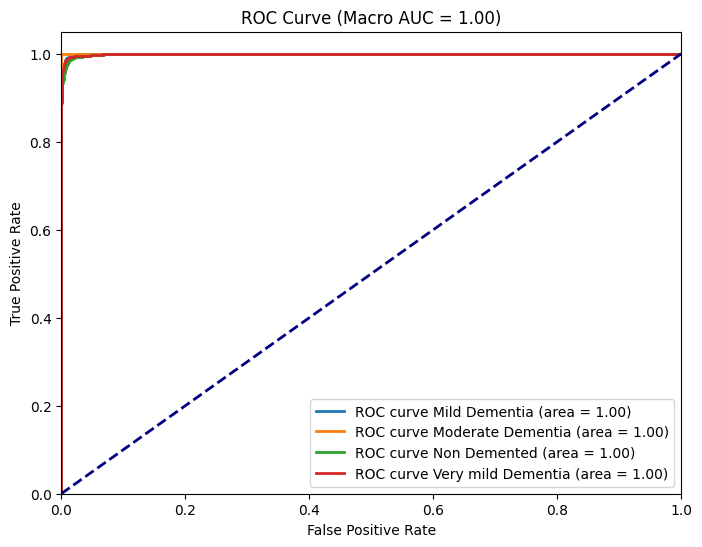

In [17]:
class_labels = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

model = models.mobilenet_v3_large(pretrained=True)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/MobileNetBrain.pth", map_location=device))
model = model.to(device)
model.eval()

y_true = []
y_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)

        y_probs.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_auc = np.mean(list(roc_auc.values()))

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve {class_labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Macro AUC = {macro_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

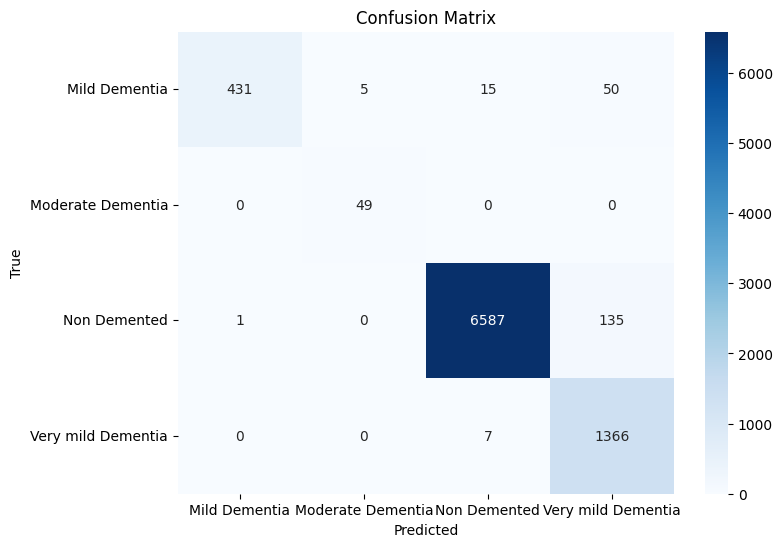

                    precision    recall  f1-score   support

     Mild Dementia       1.00      0.86      0.92       501
 Moderate Dementia       0.91      1.00      0.95        49
      Non Demented       1.00      0.98      0.99      6723
Very mild Dementia       0.88      0.99      0.93      1373

          accuracy                           0.98      8646
         macro avg       0.95      0.96      0.95      8646
      weighted avg       0.98      0.98      0.98      8646



In [21]:
y_pred = np.argmax(y_probs, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

<ipython-input-16-6b50239ae929>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/MobileNetBrain.pth", map_location=d

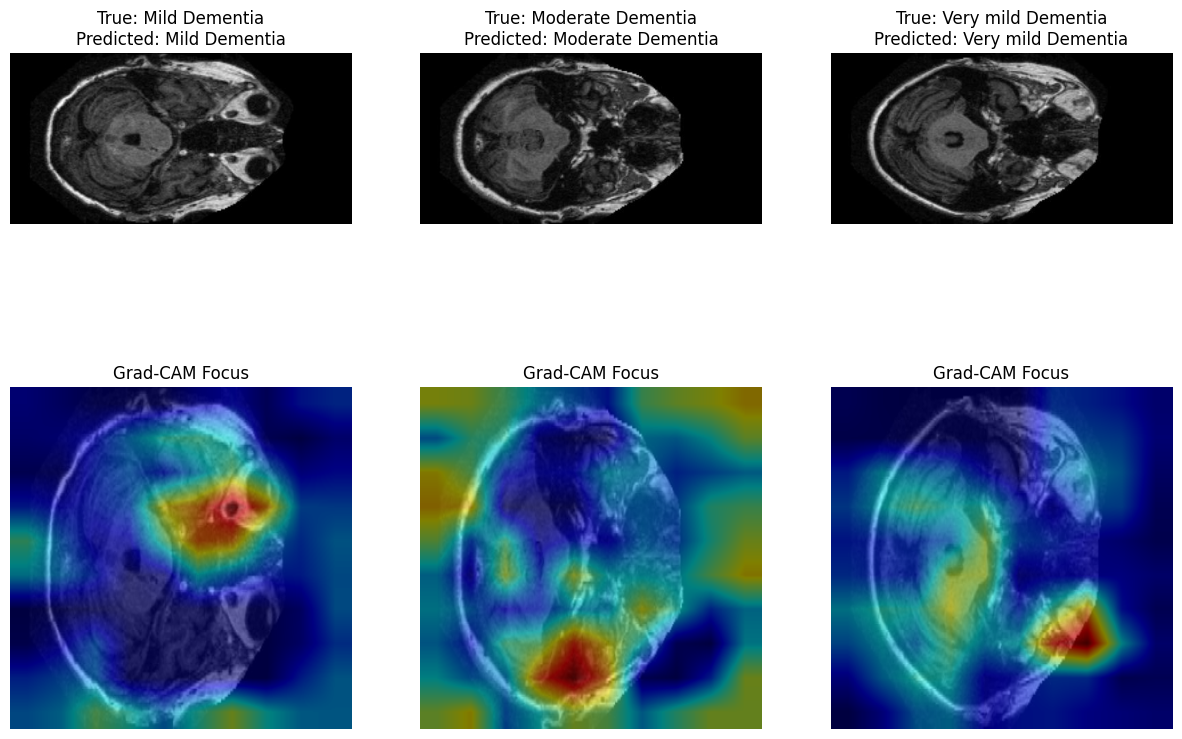

In [16]:
model = models.mobilenet_v3_large(pretrained=True)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/MobileNetBrain.pth", map_location=device))
model = model.to(device)
model.eval()
class_labels = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

def get_gradcam(model, image_tensor, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle_backward = target_layer.register_backward_hook(backward_hook)
    handle_forward = target_layer.register_forward_hook(forward_hook)

    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)
    model.zero_grad()
    output[0, predicted_class].backward()

    handle_backward.remove()
    handle_forward.remove()

    gradients = gradients[0].cpu().detach().numpy()
    activations = activations[0].cpu().detach().numpy()

    weights = np.mean(gradients, axis=(2, 3), keepdims=True)
    gradcam = np.sum(weights * activations, axis=1)
    gradcam = np.maximum(gradcam, 0)
    gradcam = gradcam[0]
    gradcam = cv2.resize(gradcam, (300, 300))
    gradcam = gradcam - np.min(gradcam)
    gradcam = gradcam / np.max(gradcam)
    return gradcam, predicted_class.item()

transform = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_paths = [
    "/content/Processed_Data/test/Mild Dementia/OAS1_0028_MR1_mpr-1_104.jpg",
    "/content/Processed_Data/test/Moderate Dementia/OAS1_0308_MR1_mpr-1_108.jpg",
    "/content/Processed_Data/test/Very mild Dementia/OAS1_0003_MR1_mpr-1_122.jpg"
]

target_layer = model.features[-1]
fig, axes = plt.subplots(2, len(image_paths), figsize=(15, 10))

for idx, image_path in enumerate(image_paths):
    true_label = os.path.basename(os.path.dirname(image_path))
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)

    gradcam, predicted_class = get_gradcam(model, transformed_image, target_layer)
    predicted_label = class_labels[predicted_class]

    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(np.array(image.resize((300, 300))), 0.5, heatmap, 0.5, 0)

    axes[0, idx].imshow(image)
    axes[0, idx].axis("off")
    axes[0, idx].set_title(f"True: {true_label}\nPredicted: {predicted_label}")

    axes[1, idx].imshow(overlay)
    axes[1, idx].axis("off")
    axes[1, idx].set_title("Grad-CAM Focus")

plt.show()